<a href="https://colab.research.google.com/github/Rekyb415/Stock-Price-Prediction/blob/main/stock_price_prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MÔ TẢ BÀI TOÁN: Cần dự đoán giá đóng cửa của ngày mai bằng cách sử dụng dữ liệu hôm nay. Nếu mô hình nói rằng giá sẽ tăng, chúng ta sẽ mua cổ phiếu. Nếu mô hình nói rằng giá sẽ giảm, chúng ta sẽ không làm gì cả.

Chúng ta muốn tối đa hóa true positives những ngày mà mô hình dự đoán rằng giá sẽ tăng và nó thực sự tăng. Do đó, chúng ta sẽ sử dụng độ Precision làm MAE cho mô hình, đó là true positives / (false positives + true positives). Điều này sẽ đảm bảo rằng chúng ta giảm thiểu số tiền mà chúng ta mất do xác định sai (những ngày chúng ta mua cổ phiếu, nhưng giá thực tế lại giảm).

Điều này có nghĩa là chúng ta sẽ phải chấp nhận rất nhiều false negatives (chúng ta dự đoán rằng giá sẽ giảm nhưng thực tế lại tăng). Nhưng không sao vì chúng ta muốn giảm thiểu tổn thất hơn là tối đa hóa lợi ích.

Vì vậy, mô hình cần thấp recall, nhưng cao precision. 

# KHAI BÁO THƯ VIỆN

In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 8.0 MB/s 
     |████████████████████████████████| 112 kB 65.1 MB/s 
     |████████████████████████████████| 128 kB 80.3 MB/s 
     |████████████████████████████████| 62 kB 1.8 MB/s 
     |████████████████████████████████| 110 kB 69.4 MB/s 
     |████████████████████████████████| 4.0 MB 59.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
from pandas_datareader import data as pdr
import seaborn as sns
import yfinance as yf
import datetime as dt
from sklearn import neighbors, datasets

# ĐỌC DỮ LIỆU 

In [ ]:
yf.pdr_override()

Lấy dữ liệu từ datasource

In [ ]:
start_date = dt.datetime(2012,11,1)
end_date = dt.datetime(2022,11,1)

Lấy dữ liệu chứng khoán trong 10 năm của Microsoft từ Yahoo Finance. Có thể lấy dữ liệu từ google, fred, quandl, worldbank

In [ ]:
MSFT = pdr.get_data_yahoo('MSFT', start=start_date, end=end_date)
MSFT

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-11-01,28.840000,29.559999,28.820000,29.520000,24.142984,72047900
2012-11-02,29.590000,29.770000,29.330000,29.500000,24.126627,57131600
2012-11-05,29.620001,29.740000,29.330000,29.629999,24.232943,38070800
2012-11-06,29.820000,30.200001,29.610001,29.860001,24.421057,43401500
2012-11-07,29.530001,29.830000,29.049999,29.080000,23.783127,57871800
...,...,...,...,...,...,...
2022-10-25,247.259995,251.039993,245.830002,250.660004,249.955582,34775500
2022-10-26,231.169998,238.300003,230.059998,231.320007,230.669937,82543200
2022-10-27,231.039993,233.690002,225.779999,226.750000,226.112778,40424600


Tương tự với Netflix

In [ ]:
NFLX = pdr.get_data_yahoo('NFLX', start=start_date, end= end_date)
NFLX

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-11-01,11.121429,11.384286,10.664286,11.098571,11.098571,62669600
2012-11-02,11.035714,11.407143,10.852857,10.985714,10.985714,29650600
2012-11-05,10.652857,11.277143,10.642857,11.177143,11.177143,29016400
2012-11-06,11.008571,11.421429,10.815714,10.910000,10.910000,39102700
2012-11-07,10.918571,11.321429,10.918571,11.097143,11.097143,31099600
...,...,...,...,...,...,...
2022-10-25,286.950012,297.589996,285.549988,291.019989,291.019989,15100700
2022-10-26,290.040009,305.630005,288.040009,298.619995,298.619995,15714100
2022-10-27,298.329987,305.209991,294.779999,296.940002,296.940002,14612600


Tương tự với Apple

In [ ]:
AAPL = pdr.get_data_yahoo('AAPL', start=start_date, end= end_date)
AAPL

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-11-01,21.365000,21.535713,21.220358,21.305000,18.238733,361298000
2012-11-02,21.281786,21.319643,20.526787,20.600000,17.635204,599373600
2012-11-05,20.840000,20.991785,20.628571,20.879286,17.874289,529135600
2012-11-06,21.079643,21.097857,20.717501,20.816071,17.820169,374917200
2012-11-07,20.494286,20.519285,19.848213,19.928572,17.138323,793648800
...,...,...,...,...,...,...
2022-10-25,150.089996,152.490005,149.360001,152.339996,152.087708,74732300
2022-10-26,150.960007,151.990005,148.039993,149.350006,149.102661,88194300
2022-10-27,148.070007,149.050003,144.130005,144.800003,144.560196,109180200


Tạo 1 list_banks là tên các mã cổ phiếu trên để dễ kiểm tra dữ liệu

In [ ]:
list_companies = ['MSFT', 'AAPL', 'NFLX']

In [ ]:
# Tham số axis = 1 là nối theo cột
comp_stocks = pd.concat([MSFT,AAPL,NFLX],axis=1, keys = list_companies)

In [ ]:
comp_stocks

MSFT                                                  \
                  Open        High         Low       Close   Adj Close   
Date                                                                     
2012-11-01   28.840000   29.559999   28.820000   29.520000   24.142984   
2012-11-02   29.590000   29.770000   29.330000   29.500000   24.126627   
2012-11-05   29.620001   29.740000   29.330000   29.629999   24.232943   
2012-11-06   29.820000   30.200001   29.610001   29.860001   24.421057   
2012-11-07   29.530001   29.830000   29.049999   29.080000   23.783127   
...                ...         ...         ...         ...         ...   
2022-10-25  247.259995  251.039993  245.830002  250.660004  249.955582   
2022-10-26  231.169998  238.300003  230.059998  231.320007  230.669937   
2022-10-27  231.039993  233.690002  225.779999  226.750000  226.112778   
2022-10-28  226.240005  236.600006  226.050003  235.869995  235.207138   
2022-10-31  233.759995  234.919998  231.149994  232.130005  231.477661   

                            AAPL                                      \
              Volume        Open        High         Low       Close   
Date                                                                   
2012-11-01  72047900   21.365000   21.535713   21.220358   21.305000   
2012-11-02  57131600   21.281786   21.319643   20.526787   20.600000   
2012-11-05  38070800   20.840000   20.991785   20.628571   20.879286   
2012-11-06  43401500   21.079643   21.097857   20.717501   20.816071   
2012-11-07  57871800   20.494286   20.519285   19.848213   19.928572   
...              ...         ...         ...         ...         ...   
2022-10-25  34775500  150.089996  152.490005  149.360001  152.339996   
2022-10-26  82543200  150.960007  151.990005  148.039993  149.350006   
2022-10-27  40424600  148.070007  149.050003  144.130005  144.800003   
2022-10-28  40647700  148.199997  157.500000  147.820007  155.740005   
2022-10-31  28357300  153.160004  154.240005  151.919998  153.339996   

                                         NFLX                          \
             Adj Close     Volume        Open        High         Low   
Date                                                                    
2012-11-01   18.238733  361298000   11.121429   11.384286   10.664286   
2012-11-02   17.635204  599373600   11.035714   11.407143   10.852857   
2012-11-05   17.874289  529135600   10.652857   11.277143   10.642857   
2012-11-06   17.820169  374917200   11.008571   11.421429   10.815714   
2012-11-07   17.138323  793648800   10.918571   11.321429   10.918571   
...                ...        ...         ...         ...         ...   
2022-10-25  152.087708   74732300  286.950012  297.589996  285.549988   
2022-10-26  149.102661   88194300  290.040009  305.630005  288.040009   
2022-10-27  144.560196  109180200  298.329987  305.209991  294.779999   
2022-10-28  155.482086  164762400  297.700012  301.190002  292.290009   
2022-10-31  153.086044   97943200  295.130005  297.619995  289.500000   

                                              
                 Close   Adj Close    Volume  
Date                                          
2012-11-01   11.098571   11.098571  62669600  
2012-11-02   10.985714   10.985714  29650600  
2012-11-05   11.177143   11.177143  29016400  
2012-11-06   10.910000   10.910000  39102700  
2012-11-07   11.097143   11.097143  31099600  
...                ...         ...       ...  
2022-10-25  291.019989  291.019989  15100700  
2022-10-26  298.619995  298.619995  15714100  
2022-10-27  296.940002  296.940002  14612600  
2022-10-28  295.720001  295.720001   9960500  
2022-10-31  291.880005  291.880005   7505100  

[2517 rows x 18 columns]

# MÔ TẢ DỮ LIỆU

In [ ]:
# Kiểm tra dữ liệu có NULL hay không 
comp_stocks.isna().any()

MSFT  Open         False
      High         False
      Low          False
      Close        False
      Adj Close    False
      Volume       False
AAPL  Open         False
      High         False
      Low          False
      Close        False
      Adj Close    False
      Volume       False
NFLX  Open         False
      High         False
      Low          False
      Close        False
      Adj Close    False
      Volume       False
dtype: bool

In [ ]:
# Kích thước của từng tập dữ liệu
NFLX.shape

(2517, 6)

In [ ]:
MSFT.shape

(2517, 6)

In [ ]:
AAPL.shape

(2517, 6)

In [ ]:
# Dữ liệu 5 dòng đầu của từng tập dữ liệu
NFLX.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-11-01,11.121429,11.384286,10.664286,11.098571,11.098571,62669600
2012-11-02,11.035714,11.407143,10.852857,10.985714,10.985714,29650600
2012-11-05,10.652857,11.277143,10.642857,11.177143,11.177143,29016400
2012-11-06,11.008571,11.421429,10.815714,10.910000,10.910000,39102700
2012-11-07,10.918571,11.321429,10.918571,11.097143,11.097143,31099600


In [ ]:
MSFT.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-11-01,28.840000,29.559999,28.820000,29.520000,24.142984,72047900
2012-11-02,29.590000,29.770000,29.330000,29.500000,24.126627,57131600
2012-11-05,29.620001,29.740000,29.330000,29.629999,24.232943,38070800
2012-11-06,29.820000,30.200001,29.610001,29.860001,24.421057,43401500
2012-11-07,29.530001,29.830000,29.049999,29.080000,23.783127,57871800


In [ ]:
AAPL.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-11-01,21.365000,21.535713,21.220358,21.305000,18.238733,361298000
2012-11-02,21.281786,21.319643,20.526787,20.600000,17.635204,599373600
2012-11-05,20.840000,20.991785,20.628571,20.879286,17.874289,529135600
2012-11-06,21.079643,21.097857,20.717501,20.816071,17.820169,374917200
2012-11-07,20.494286,20.519285,19.848213,19.928572,17.138323,793648800


In [ ]:
# Xác định kiểu dữ liệu
comp_stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2012-11-01 to 2022-10-31
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (MSFT, Open)       2517 non-null   float64
 1   (MSFT, High)       2517 non-null   float64
 2   (MSFT, Low)        2517 non-null   float64
 3   (MSFT, Close)      2517 non-null   float64
 4   (MSFT, Adj Close)  2517 non-null   float64
 5   (MSFT, Volume)     2517 non-null   int64  
 6   (AAPL, Open)       2517 non-null   float64
 7   (AAPL, High)       2517 non-null   float64
 8   (AAPL, Low)        2517 non-null   float64
 9   (AAPL, Close)      2517 non-null   float64
 10  (AAPL, Adj Close)  2517 non-null   float64
 11  (AAPL, Volume)     2517 non-null   int64  
 12  (NFLX, Open)       2517 non-null   float64
 13  (NFLX, High)       2517 non-null   float64
 14  (NFLX, Low)        2517 non-null   float64
 15  (NFLX, Close)      2517 non-null   float64
 16  (NFLX,

Dữ liệu có 2517 dòng, không dữ liệu nào rỗng, mỗi công ty với 5 cột là kiểu dữ liệu số thực và 1 cột kiểu số nguyên, tổng cộng 6 cột và index định dạng Datetime


In [ ]:
# Mô tả dữ liệu
comp_stocks.describe()

MSFT                                                      \
              Open         High          Low        Close    Adj Close   
count  2517.000000  2517.000000  2517.000000  2517.000000  2517.000000   
mean    118.252571   119.422443   117.026778   118.283810   113.702824   
std      89.282554    90.247125    88.234598    89.281542    90.201861   
min      26.379999    26.629999    26.260000    26.370001    21.743969   
25%      46.380001    46.880001    46.029999    46.520000    40.671776   
50%      82.400002    82.800003    81.430000    82.400002    77.597321   
75%     182.850006   184.460007   181.100006   182.919998   178.551300   
max     344.619995   349.670013   342.200012   343.109985   339.924835   

                            AAPL                                         \
             Volume         Open         High          Low        Close   
count  2.517000e+03  2517.000000  2517.000000  2517.000000  2517.000000   
mean   3.267989e+07    60.352384    61.031946    59.701825    60.393395   
std    1.716336e+07    47.842517    48.471034    47.246272    47.887129   
min    7.425600e+06    13.856071    14.271429    13.753571    13.947500   
25%    2.249860e+07    26.395000    26.625000    26.205000    26.440001   
50%    2.861650e+07    39.767502    40.052502    39.412498    39.667500   
75%    3.728510e+07    79.457497    80.112503    78.912498    79.577499   
max    2.484285e+08   182.630005   182.940002   179.119995   182.009995   

                                         NFLX                            \
         Adj Close        Volume         Open         High          Low   
count  2517.000000  2.517000e+03  2517.000000  2517.000000  2517.000000   
mean     58.568590  1.800284e+08   234.454370   238.065581   230.657952   
std      48.398782  1.398459e+08   176.566351   178.993458   173.883632   
min      12.064587  4.100000e+07    10.652857    11.268571    10.642857   
25%      24.156105  9.398400e+07    81.028572    82.142860    79.949997   
50%      37.839714  1.335464e+08   184.259995   187.210007   181.250000   
75%      78.185623  2.124976e+08   361.959991   367.329987   356.619995   
max     180.959732  1.460852e+09   692.349976   700.989990   686.090027   

                                               
             Close    Adj Close        Volume  
count  2517.000000  2517.000000  2.517000e+03  
mean    234.462439   234.462439  1.288495e+07  
std     176.450928   176.450928  1.260690e+07  
min      10.852857    10.852857  1.144000e+06  
25%      80.868568    80.868568  5.460500e+06  
50%     184.619995   184.619995  9.306700e+06  
75%     361.809998   361.809998  1.630250e+07  
max     691.690002   691.690002  1.914458e+08

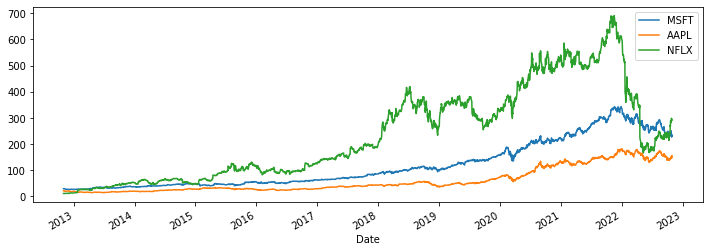

In [ ]:
# Lập biểu đồ giá đóng cửa của 3 công ty
for tick in list_companies:
    comp_stocks[tick]['Close'].plot(figsize=(12,4),label=tick)
plt.legend()

In [ ]:
comp_stocks.columns.names = ['Bank Name','Stock Info']

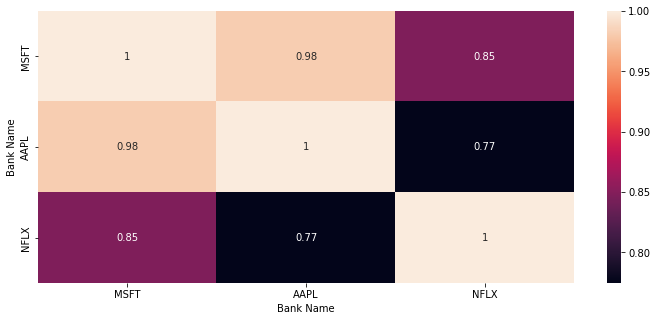

In [ ]:
plt.figure(figsize=(12,5))
sns.heatmap(comp_stocks.xs(key='Close',axis=1,level='Stock Info').corr(),annot=True)

# TIỀN XỬ LÍ DỮ LIỆU

In [ ]:
NFLX.index

DatetimeIndex(['2012-11-01', '2012-11-02', '2012-11-05', '2012-11-06',
               '2012-11-07', '2012-11-08', '2012-11-09', '2012-11-12',
               '2012-11-13', '2012-11-14',
               ...
               '2022-10-18', '2022-10-19', '2022-10-20', '2022-10-21',
               '2022-10-24', '2022-10-25', '2022-10-26', '2022-10-27',
               '2022-10-28', '2022-10-31'],
              dtype='datetime64[ns]', name='Date', length=2517, freq=None)

In [ ]:
MSFT_data = MSFT[["Adj Close"]]
NFLX_data = NFLX[["Adj Close"]]
AAPL_data = AAPL[["Adj Close"]]

# Thiết lập Target của chúng ta.  Điều này xác định khi giá tăng hoặc giảm
MSFT_data["Target"] = MSFT.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Adj Close"]
NFLX_data["Target"] = NFLX.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Adj Close"]
AAPL_data["Target"] = AAPL.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Adj Close"]

<ipython-input-24-93956c773ec1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MSFT_data["Target"] = MSFT.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Adj Close"]
<ipython-input-24-93956c773ec1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NFLX_data["Target"] = NFLX.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Adj Close"]
<ipython-input-24-93956c773ec1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [ ]:
MSFT_prev = MSFT.copy()
MSFT_prev = MSFT_prev.shift(1)

In [ ]:
NFLX_prev = NFLX.copy()
NFLX_prev = NFLX_prev.shift(1)

In [ ]:
AAPL_prev = AAPL.copy()
AAPL_prev = AAPL_prev.shift(1)

In [ ]:
MSFT_prev.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-11-01,NaN,NaN,NaN,NaN,NaN,NaN
2012-11-02,28.840000,29.559999,28.820000,29.520000,24.142984,72047900.0
2012-11-05,29.590000,29.770000,29.330000,29.500000,24.126627,57131600.0
2012-11-06,29.620001,29.740000,29.330000,29.629999,24.232943,38070800.0
2012-11-07,29.820000,30.200001,29.610001,29.860001,24.421057,43401500.0


In [ ]:
NFLX_prev.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-11-01,NaN,NaN,NaN,NaN,NaN,NaN
2012-11-02,11.121429,11.384286,10.664286,11.098571,11.098571,62669600.0
2012-11-05,11.035714,11.407143,10.852857,10.985714,10.985714,29650600.0
2012-11-06,10.652857,11.277143,10.642857,11.177143,11.177143,29016400.0
2012-11-07,11.008571,11.421429,10.815714,10.910000,10.910000,39102700.0


Đoạn phía trên, chúng ta sẽ sử dụng phương pháp dịch chuyển DataFrame để di chuyển tất cả các hàng “về phía trước” trong một ngày giao dịch.
Ở đây có thể thấy, giá của ngày 1 tháng 8 đang nằm trong ngày 2 tháng 8, và mọi giá khác được chuyển lên trên một hàng. Điều này nhằm đảm bảo rằng chúng ta đang dự đoán giá trong tương lai bằng cách sử dụng dữ liệu trong quá khứ.

Nếu không làm điều này, chúng ta sẽ sử dụng dữ liệu từ 2 tháng 8 để dự đoán giá trên 2 tháng 8. Thay vào đó, chúng ta cần sử dụng dữ liệu từ 1 tháng 8 để dự đoán giá trên 2 tháng 8. Nếu không làm điều đó, trong thử nghiệm mô hình vẫn tuyệt vời nhưng hoàn toàn không thể làm được trong thế giới thực. Trong thế giới thực, chúng ta không thực sự biết giá của ngày mai, vì vậy chúng ta không thể sử dụng nó để đưa ra dự đoán của mình.

In [ ]:
# Tạo bảng có x đúng với ngày hôm đó và nối với giá đóng cửa của ngày hôm trước
x = ["Close", "Volume", "Open", "High", "Low"]
MSFT_data = MSFT_data.join(MSFT_prev[x]).iloc[1:]
NFLX_data = NFLX_data.join(NFLX_prev[x]).iloc[1:]
AAPL_data = AAPL_data.join(AAPL_prev[x]).iloc[1:]

In [ ]:
MSFT_data = MSFT_data.reset_index()

In [ ]:
NFLX_data = NFLX_data.reset_index()

In [ ]:
AAPL_data = AAPL_data.reset_index()

In [ ]:
MSFT_data

,Date,Adj Close,Target,Close,Volume,Open,High,Low
0,2012-11-02,24.126627,0.0,29.520000,72047900.0,28.840000,29.559999,28.820000
1,2012-11-05,24.232943,1.0,29.500000,57131600.0,29.590000,29.770000,29.330000
2,2012-11-06,24.421057,1.0,29.629999,38070800.0,29.620001,29.740000,29.330000
3,2012-11-07,23.783127,0.0,29.860001,43401500.0,29.820000,30.200001,29.610001
4,2012-11-08,23.562311,0.0,29.080000,57871800.0,29.530001,29.830000,29.049999
...,...,...,...,...,...,...,...,...
2511,2022-10-25,249.955582,1.0,247.250000,24911200.0,243.759995,247.839996,241.300003
2512,2022-10-26,230.669937,0.0,250.660004,34775500.0,247.259995,251.039993,245.830002
2513,2022-10-27,226.112778,0.0,231.320007,82543200.0,231.169998,238.300003,230.059998
2514,2022-10-28,235.207138,1.0,226.750000,40424600.0,231.039993,233.690002,225.779999


Sử dụng thuật toán phân loại vì mục tiêu của chúng ta là nhị phân (0/1). A 1 nghĩa là giá tăng, a 0 nghĩa là nó giảm. Nếu chúng tôi có một loại mục tiêu khác (chẳng hạn như giá thực tế), chúng tôi có thể sử dụng thuật toán hồi quy.

#RANDOM FOREST REGRESSION

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
# Lập mô hình random forest classification.  Thiết lập min_samples_split cao để tránh tình trạng overfit.
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

##MICROSOFT

In [ ]:
# Chia tập dữ liệu của Microsoft
X_train = MSFT_data[MSFT_data.Date.dt.year < 2022][x] 
y_train = MSFT_data[MSFT_data.Date.dt.year < 2022]['Target']
X_test = MSFT_data[MSFT_data.Date.dt.year == 2022][x]
y_test = MSFT_data[MSFT_data.Date.dt.year == 2022]['Target']

In [ ]:
X_train.shape

(2307, 5)

In [ ]:
X_test.shape

(209, 5)

In [ ]:
model.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=200, random_state=1)

In [ ]:
from sklearn.metrics import precision_score

# Sử dụng precision_score
y_pred = model.predict(X_test)
precision_score(y_test, y_pred)

0.4624277456647399

### TINH CHỈNH MÔ HÌNH RANDOM FOREST

##### Random Forest sử dụng GridSearchCV

In [ ]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,9],
    'criterion' :['gini', 'entropy']
}

In [ ]:
CV_model = GridSearchCV(estimator=model, param_grid=param_grid, cv= 5)
CV_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(min_samples_split=200,
                                              random_state=1),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 9],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

In [ ]:
CV_model.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'max_features': 'auto',
 'n_estimators': 200}

In [ ]:
model1 = RandomForestClassifier(random_state=1, max_features='auto', n_estimators=200, max_depth=9, criterion='gini', min_samples_split=200)

In [ ]:
model1.fit(X_train, y_train)

RandomForestClassifier(max_depth=9, min_samples_split=200, n_estimators=200,
                       random_state=1)

In [ ]:
from sklearn.metrics import precision_score

# Sử dụng precision_score
y_pred = model1.predict(X_test)
precision_score(y_test, y_pred)

0.4577114427860697

##### Tạo thêm đặc trưng

Có thể tạo thêm các đặc trưng giá trị trung bình, tổng trong khoảng thời gian 1 tuần, 3 tháng, 1 năm để tăng độ chính xác của mô hình bởi vì chúng ta đang làm việc với bộ dữ liệu chuỗi thời gian
VD: Nếu giá bây giờ cao hơn giá hàng năm, điều đó có thể có nghĩa là cổ phiếu đang có xu hướng tăng

In [ ]:
#Tính trung bình của giá đóng trên tập dữ liệu Microsoft trong 1 tuần, 1 quý và 1 năm.
weekly_mean = MSFT_data.rolling(7).mean()["Close"]
quarterly_mean = MSFT_data.rolling(90).mean()["Close"]
annual_mean = MSFT_data.rolling(365).mean()["Close"]

In [ ]:
#Tính xu hướng hàng tuần bằng cách cộng Target trong tuần 
#Chuyển dữ liệu về phía trước, để không kết hợp thông tin từ ngày hiện tại vào công cụ dự đoán. Nếu chúng ta không sử dụng shift, thì thuật toán sẽ biết về mục tiêu thực tế.
#Tìm tổng số tiền trong 7 ngày của mục tiêu. Nếu giá tăng trong cả 7 ngày, thì đây sẽ là 7. Nếu nó tăng lên 0 ngày, đây sẽ là 0.
weekly_trend = MSFT_data.shift(1).rolling(7).sum()["Target"]
#thêm xu hướng hàng tuần vào dữ liệu dự đoán 
MSFT_data["weekly_trend"] = weekly_trend

In [ ]:
#tỷ lệ giữa giá đóng với hàng tuần, hàng quý và hàng năm
MSFT_data["weekly_mean"] = weekly_mean / MSFT_data["Close"]
MSFT_data["quarterly_mean"] = quarterly_mean / MSFT_data["Close"]
MSFT_data["annual_mean"] = annual_mean / MSFT_data["Close"]

In [ ]:
#thêm vào các tỷ lệ giữa các trung bình khác nhau. Điều này giúp thuật toán hiểu xu hướng hàng tuần có liên quan gì đến xu hướng hàng năm
MSFT_data["annual_weekly_mean"] = MSFT_data["annual_mean"] / MSFT_data["weekly_mean"]
MSFT_data["annual_quarterly_mean"] = MSFT_data["annual_mean"] / MSFT_data["quarterly_mean"]

In [ ]:
#thêm một số tỷ lệ giữa giá mở cửa, thấp và cao trong ngày và giá đóng cửa. Điều này giúp thuật toán hiểu xu hướng giá trong ngày vừa qua. 
#Ví dụ: nếu mức cao cao hơn nhiều so với giá đóng cửa, điều đó có thể có nghĩa là cổ phiếu đang có xu hướng giảm vào cuối ngày.
MSFT_data["open_close_ratio"] = MSFT_data["Open"] / MSFT_data["Close"]
MSFT_data["high_close_ratio"] = MSFT_data["High"] / MSFT_data["Close"]
MSFT_data["low_close_ratio"] = MSFT_data["Low"] / MSFT_data["Close"]

In [ ]:
MSFT_x = x + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "open_close_ratio", "high_close_ratio", "low_close_ratio"]

In [ ]:
MSFT_x

['Close',
 'Volume',
 'Open',
 'High',
 'Low',
 'weekly_mean',
 'quarterly_mean',
 'annual_mean',
 'annual_weekly_mean',
 'annual_quarterly_mean',
 'open_close_ratio',
 'high_close_ratio',
 'low_close_ratio']

Tạo một hàm để dễ sử dụng cho những lần sử dụng sau, có thể tránh viết lại mã nếu muốn kiểm tra lại lần nữa


In [ ]:
def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()

        # Fit the random forest model
        model.fit(train[predictors], train["Target"])

        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1] #sử dụng phương thức predict_proba . Phương pháp này cho phép chúng ta có được xác suất thô, không chỉ 0/1
        preds = pd.Series(preds, index=test.index)  #chuyển đổi kết quả từ một mảng numby thành một Series pandas để làm việc dễ dàng hơn
        preds[preds > .6] = 1 #sử dụng .6 như một ngưỡng cho dù giá có tăng hay không. Nếu sử dụng ngưỡng thấp hơn, sẽ tăng recall, nhưng precision thấp hơn. Vì chúng ta muốn giảm thiểu rủi ro nên cần tối đa hóa độ chính xác. Vì vậy, sẽ không sao nếu thuật toán chỉ dự đoán giá sẽ tăng trong vài ngày.
        preds[preds<=.6] = 0

        # Kết hợp giá trị dự đoán và giá trị thực
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)

        predictions.append(combined)

    return pd.concat(predictions)

### KẾT QUẢ

In [ ]:
predictions = backtest(MSFT_data[365:], model1, MSFT_x)

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5483870967741935

In [ ]:
from sklearn.metrics import recall_score
recall_score(predictions["Target"], predictions["Predictions"])

0.05466237942122187

Mô hình đã tinh chỉnh: 0.46 -> 0.46 -> 0.54

##NETFLIX

In [ ]:
X1_train = NFLX_data[NFLX_data.Date.dt.year < 2022][x] 
y1_train = NFLX_data[NFLX_data.Date.dt.year < 2022]['Target']
X1_test = NFLX_data[NFLX_data.Date.dt.year == 2022][x]
y1_test = NFLX_data[NFLX_data.Date.dt.year == 2022]['Target']

In [ ]:
model.fit(X1_train, y1_train)

RandomForestClassifier(min_samples_split=200, random_state=1)

In [ ]:
y1_pred = model.predict(X1_test)
precision_score(y1_test, y1_pred)

0.44755244755244755

In [ ]:
model1.fit(X1_train, y1_train)

RandomForestClassifier(max_depth=9, min_samples_split=200, n_estimators=200,
                       random_state=1)

In [ ]:
y1_pred = model1.predict(X1_test)
precision_score(y1_test, y1_pred)

0.46099290780141844

Làm tương tự với Microsoft. Lần này chúng ta sẽ sử dung thẳng mô hình huấn luyện cuối cùng

### Tạo thêm đặc trưng

In [ ]:
weekly_mean = NFLX_data.rolling(7).mean()["Close"]
quarterly_mean = NFLX_data.rolling(90).mean()["Close"]
annual_mean = NFLX_data.rolling(365).mean()["Close"]

weekly_trend = NFLX_data.shift(1).rolling(7).sum()["Target"]
NFLX_data["weekly_trend"] = weekly_trend

NFLX_data["weekly_mean"] = weekly_mean / NFLX_data["Close"]
NFLX_data["quarterly_mean"] = quarterly_mean / NFLX_data["Close"]
NFLX_data["annual_mean"] = annual_mean / NFLX_data["Close"]

NFLX_data["annual_weekly_mean"] = NFLX_data["annual_mean"] / NFLX_data["weekly_mean"]
NFLX_data["annual_quarterly_mean"] = NFLX_data["annual_mean"] / NFLX_data["quarterly_mean"]

NFLX_data["open_close_ratio"] = NFLX_data["Open"] / NFLX_data["Close"]
NFLX_data["high_close_ratio"] = NFLX_data["High"] / NFLX_data["Close"]
NFLX_data["low_close_ratio"] = NFLX_data["Low"] / NFLX_data["Close"]

In [ ]:
NFLX_x = x + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "open_close_ratio", "high_close_ratio", "low_close_ratio"]

###KẾT QUẢ

In [ ]:
predictions = backtest(NFLX_data.iloc[365:], model1, NFLX_x)

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5835777126099707

precision của NFLX cao hơn MSFT

## APPLE

In [ ]:
X2_train = AAPL_data[AAPL_data.Date.dt.year < 2022][x] 
y2_train = AAPL_data[AAPL_data.Date.dt.year < 2022]['Target']
X2_test = AAPL_data[AAPL_data.Date.dt.year == 2022][x]
y2_test = AAPL_data[AAPL_data.Date.dt.year == 2022]['Target']

In [ ]:
model.fit(X2_train, y2_train)

RandomForestClassifier(min_samples_split=200, random_state=1)

In [ ]:
y2_pred = model.predict(X2_test)
precision_score(y2_test, y2_pred)

0.48044692737430167

In [ ]:
model1.fit(X2_train, y2_train)

RandomForestClassifier(max_depth=9, min_samples_split=200, n_estimators=200,
                       random_state=1)

In [ ]:
y2_pred = model1.predict(X2_test)
precision_score(y2_test, y2_pred)

0.49740932642487046

### Tạo thêm đặc trưng

In [ ]:
weekly_mean = AAPL_data.rolling(7).mean()["Close"]
quarterly_mean = AAPL_data.rolling(90).mean()["Close"]
annual_mean = AAPL_data.rolling(365).mean()["Close"]

weekly_trend = AAPL_data.shift(1).rolling(7).sum()["Target"]
AAPL_data["weekly_trend"] = weekly_trend

AAPL_data["weekly_mean"] = weekly_mean / AAPL_data["Close"]
AAPL_data["quarterly_mean"] = quarterly_mean / AAPL_data["Close"]
AAPL_data["annual_mean"] = annual_mean / AAPL_data["Close"]

AAPL_data["annual_weekly_mean"] = AAPL_data["annual_mean"] / AAPL_data["weekly_mean"]
AAPL_data["annual_quarterly_mean"] = AAPL_data["annual_mean"] / AAPL_data["quarterly_mean"]

AAPL_data["open_close_ratio"] = AAPL_data["Open"] / AAPL_data["Close"]
AAPL_data["high_close_ratio"] = AAPL_data["High"] / AAPL_data["Close"]
AAPL_data["low_close_ratio"] = AAPL_data["Low"] / AAPL_data["Close"]

In [ ]:
AAPL_x = x + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "open_close_ratio", "high_close_ratio", "low_close_ratio"]

### KẾT QUẢ

In [ ]:
predictions = backtest(AAPL_data.iloc[365:], model1, AAPL_x)

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

0.6428571428571429

Cao hơn nhiều so với NFLX và MSFT